#### RL Course by David Silver

## Reinforcement Learning Assignment: Easy21

The goal of this assignment is to apply reinforcement learning methods to a simple card game that we call *Easy21*. This exercise is similar to the Blackjack example in Sutton and Barto 5.3 – please note, however, that the rules of the card game are different and non-standard.

 - The game is played with an infinite deck of cards (i.e. cards are sample with replacement)
 - Each draw from the deck results in a value between 1 and 10 (uniforml distributed) with a colour of red (probability 1/3) or black (probability 2/3).
 - There are no aces or picture (face) cards in this game
 - At the start of the game both the player and the dealer draw one *black* card (fully observed)
 - Each turn the player may either *stick* or *hit*
 - If the player *hits* then she draws another card from the deck
 - If the player *sticks* she receives no further cards
 - The values of the player’s cards are added (black cards) or subtracted (red cards)
 - If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1)
 - If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

In [11]:
%matplotlib notebook
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from gym.utils import seeding

## 1 Implementation of Easy21

In [2]:
from lib.envs.easy21 import Easy21Env

env = Easy21Env()
s = env.reset()
done = False
while not done:
    s, r, done, _ = env.step(np.random.randint(2))
    print(s, r, done)

(9, 5) -1 True


In [3]:
def naive_policy(state):
    return 1 if state[0] < 20 else 0

In [4]:
from collections import defaultdict, Counter,deque
def MC_Learning(MDP, episodes, policy, gamma = 1):
    episode = 0
    V = defaultdict(float)
    N = Counter()
    while episode < episodes:
        S = deque()
        R = deque()
        G = 0
        s = MDP.reset()
        done = False
        while not done:
            S.append(s)
            a = policy(s)
            s, r, done, _ = MDP.step(a)
            R.append(r)
        while len(S) > 0:
            s = S.pop()
            r = R.pop()
            G = gamma * G + r
            N[s] += 1
            V[s] += (G - V[s])/ N[s]
        episode += 1
    return V

In [9]:
def plot_value_function(V, title, fig = None, pos = None):
    max_x = max(x[0] for x in V)
    min_x = min(x[0] for x in V)
    max_y = max(x[1] for x in V)
    min_y = min(x[1] for x in V)
    
    x = np.arange(min_x, max_x+1)           # 生成 x 坐标，表示玩家此刻的点数
    y = np.arange(min_y, max_y+1)             # 生成 y 坐标，表示庄家的明牌
    X, Y = np.meshgrid(x, y)        # 生成 meshgrid
    # 画图
    Z = np.apply_along_axis(lambda _: V[(_[0], _[1])], 2, np.dstack([X, Y]))
    if fig is None:
        fig = plt.figure()
        ax = Axes3D(fig)
    else:
        ax = fig.add_subplot(pos, projection='3d')
    ax.plot_surface(Y, X, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, vmin=-1, vmax=1)
    ax.set_xlabel("Dealer's face-up card")
    ax.set_ylabel("Player's Points")
    fig.suptitle(title)

In [91]:
def plot_Q_function(Q, title, epsilon, fig = None, pos = None):
    V = defaultdict(float)
    for s in Q.keys():
        V[s] = np.max(Q[s]) * (1 - epsilon) + np.sum(Q[s]) * epsilon
    plot_value_function(V, title, fig, pos)

In [69]:
def plot_policy_from_Q(Q, tittle):
    V = defaultdict(float)
    for s in Q.keys():
        V[s] = np.argmax(Q[s])
    max_x = max(x[0] for x in V)
    min_x = min(x[0] for x in V)
    max_y = max(x[1] for x in V)
    min_y = min(x[1] for x in V)
    x = np.arange(min_x, max_x+1)
    y = np.arange(min_y, max_y+1)
    print('%2d'%0, end=' ')
    for n in x:
        print('%2d'%n, end=' ')
    print()
    for m in y:
        print(m, end=' ')
        for n in x:
            print(' x' if V[(m, n)]==1 else ' o', end=' ')
        print()

In [53]:
env = Easy21Env()
V_mc = MC_Learning(env, 100000, naive_policy)

<IPython.core.display.Javascript object>


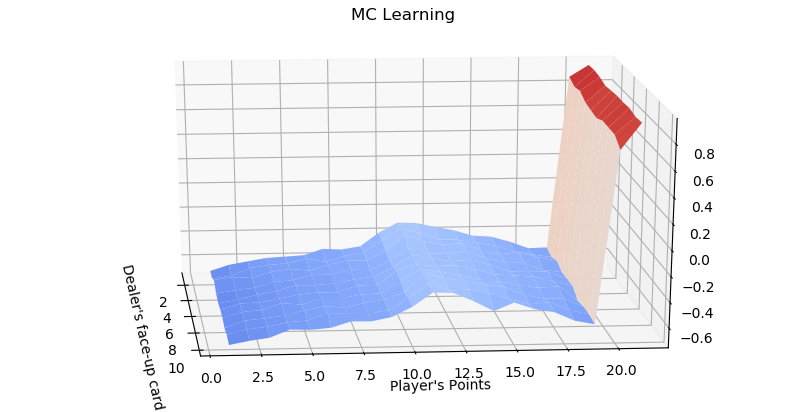

In [54]:
plot_value_function(V_mc, 'MC Learning')

In [73]:
def improve_greedy_policy(Q, epsilon, nA):
    def policy(state):
        prob = np.ones(nA) * epsilon / nA
        prob[np.argmax(Q[state])] += 1 - epsilon
        return prob
    return policy

def improve_glie_greedy_policy(Q, nA):
    def policy(state, i_episode):
        epsilon = 1. / (10 + i_episode/1000)
        prob = np.ones(nA) * epsilon / nA
        prob[np.argmax(Q[state])] += 1 - epsilon
        return prob
    return policy

In [ ]:
# GLIE Monte-Carlo Control
from collections import deque, defaultdict


def GLIE_MC(MDP, episods, gamma = 1., GLIE = True):
    '''GLIE Monte-Carlo control method. Use epsilon-greedy for improvement with a decent epsilon.
    Params:
        MDP: an instance of MDP
        episods: number of episod
        gamma: decay of reward
    
    Return:
        Q, A defaultdict(np.ndarray)
        Q[state][value]: the estimate expect of state-action pair
    '''
    N = defaultdict(lambda: np.zeros(MDP.action_space.n))
    Q = defaultdict(lambda: np.zeros(MDP.action_space.n))
    
    for i_episod in range(1, episods+1):
        if i_episod % 1000 == 0:
            print("\ri_episod:%d/%d"%(i_episod, episods), end='')
        episod = deque()
        G = 0
        s = MDP.reset()
        policy = improve_glie_greedy_policy(Q, MDP.action_space.n) if GLIE else \
            improve_greedy_policy(Q, 0.1, MDP.action_space.n)
        done = False
        while not done: # run the simulation
            prob = policy(s, i_episod) if GLIE else policy(s) 
            a = np.random.choice(np.arange(len(prob)), p=prob)
            s_n, r, done, _ = MDP.step(a)
            episod.append((s, a, r))
            s = s_n
        while len(episod) != 0: # update value evaluation of every-visit
            s, a, r = episod.pop()
            G = r + gamma * G
            N[s][a] += 1
            Q[s][a] += (G - Q[s][a])/N[s][a]
#         policy = improve_greedy_policy(Q, 1./i_episod, MDP.action_space.n) # update epsilon for descent.
    return Q

In [81]:
env = Easy21Env()
Q_glie = GLIE_MC(env, 1000000, False)

i_episod:1000000/1000000

<IPython.core.display.Javascript object>


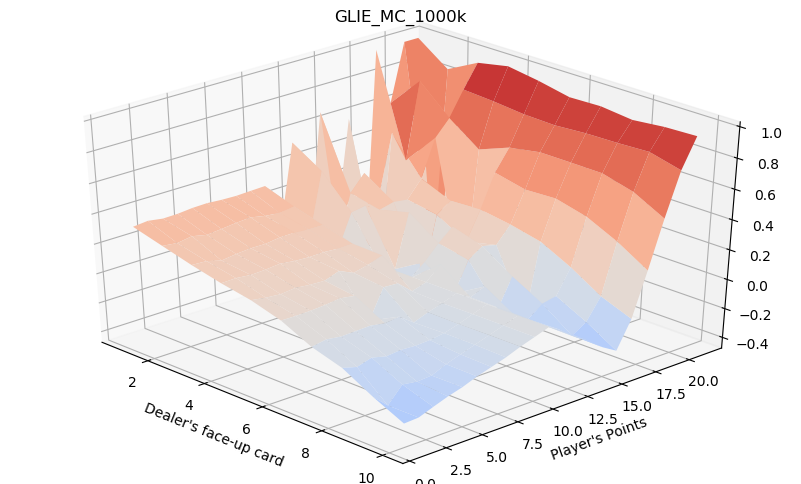

In [86]:
plot_Q_function(Q_glie, "GLIE_MC_1000k")

In [83]:
plot_policy_from_Q(Q_glie, 'hi')

 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 
1  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o 
2  o  o  o  o  o  o  o  o  x  o  o  o  o  o  o  o  o  o  o  o  o 
3  o  o  o  o  o  o  o  o  o  x  o  o  o  o  o  o  o  o  o  o  o 
4  o  o  o  o  o  o  o  o  o  x  o  o  o  o  o  o  o  o  o  o  o 
5  o  o  o  o  o  o  o  o  x  x  o  o  o  o  o  o  o  o  o  o  o 
6  o  o  o  o  o  o  o  o  x  x  o  o  o  o  o  o  o  o  o  o  o 
7  o  o  o  o  o  x  o  o  x  x  o  o  o  o  o  o  o  o  o  o  o 
8  o  o  o  o  o  o  x  x  x  x  o  o  o  o  o  o  o  o  o  o  o 
9  o  o  o  o  o  o  x  x  x  x  o  o  o  o  o  o  o  o  o  o  o 
10  o  o  o  o  o  x  x  x  x  x  o  o  o  o  o  o  o  o  o  o  o 


In [98]:
# Sarsa Algorithm
from collections import defaultdict

def Sarsa(MDP, episods, gamma = 1, alpha = 0.1, epsilon = 0.3):
    '''Sarsa Algorithm for On-policy Control
    
    Params:
        MDP: an instance of MDP
        episods: number of episod
        gamma: decay of reward
        alpha: parameter of TD-learning, learning rate
        epsilon: parameter of epsilon-greedy
        
    Return:
        Q, A defaultdict(np.ndarray)
        Q[state][value]: the estimate expect of state-action pair
    '''
    Q = defaultdict(lambda: np.zeros(MDP.action_space.n))
    policy = improve_greedy_policy(Q, epsilon, MDP.action_space.n)
    
    for i_episod in range(1, episods+1):
        if i_episod % 1000 == 0:
            print("\ri_episod:%d/%d"%(i_episod, episods), end="")
        s = MDP.reset()
        done = False
        prob = policy(s)
        a = np.random.choice(np.arange(len(prob)), p = prob)
        while not done:
            s_next, r, done, _ = MDP.step(a)
            if not done:
                prob = policy(s_next)
                a_next = np.random.choice(np.arange(len(prob)), p = prob)
                Q[s][a] += alpha * (r + gamma * Q[s_next][a_next] - Q[s][a])
                s = s_next
                a = a_next
            else:
                Q[s][a] += alpha * (r + gamma * 0 - Q[s][a]) # Q(terminate-state,.) = 0
    return Q

In [97]:
env = Easy21Env()
Q = Sarsa(env, 1000000, alpha = 0.1, epsilon = 0.4)

i_episod:1000000/1000000

<IPython.core.display.Javascript object>


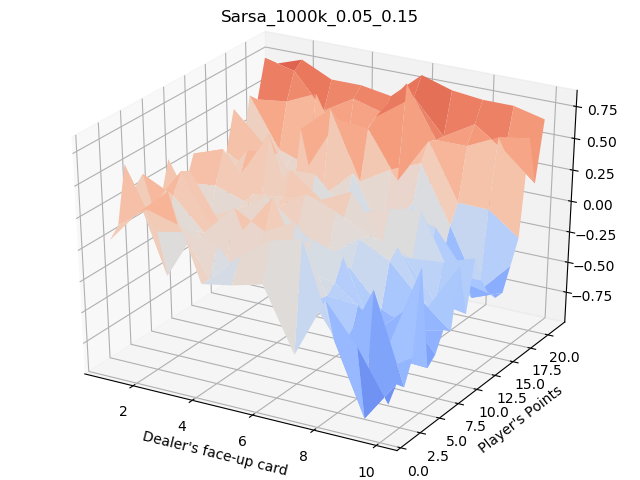

In [99]:
plot_Q_function(Q, "Sarsa_1000k_0.05_0.15",  epsilon = 0.4)

In [100]:
plot_policy_from_Q(Q, 'hi')

 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 
1  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o 
2  o  o  o  o  o  o  o  o  x  x  o  o  o  o  o  o  o  o  o  o  o 
3  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o  o 
4  o  x  o  o  o  o  o  x  o  o  o  o  o  o  o  o  o  o  o  o  o 
5  o  o  o  o  o  o  o  o  x  o  o  o  o  o  o  o  o  o  o  o  o 
6  o  o  o  o  o  x  o  o  x  x  o  o  o  o  o  o  o  o  o  o  o 
7  o  o  o  o  x  o  x  x  o  o  o  o  o  o  o  o  o  o  o  o  o 
8  o  o  o  o  x  o  x  o  x  o  o  o  o  o  o  o  o  o  o  o  o 
9  x  x  x  o  x  x  x  x  x  x  o  o  o  o  o  o  o  o  o  o  o 
10  x  x  x  x  o  o  x  o  o  o  o  o  o  o  o  o  o  o  o  o  o 


In [17]:
# Sarsa(lambda) Algorithm
from collections import defaultdict

def Sarsa_lambda(MDP, episods, gamma = 1, alpha = 0.1, epsilon = 0.3, lamda = 0.5):
    '''Sarsa Lambda with Backward view
    
    Params:
        MDP: an instance of MDP
        episods: number of episod
        gamma: decay of reward
        alpha: parameter of TD-learning, learning rate
        epsilon: parameter of epsilon-greedy
        lamda: parameter of sarsa lamda, the decay rate of n-step TD
        
    Return:
        Q, A defaultdict(np.ndarray)
        Q[state][value]: the estimate expect of state-action pair
    '''
    Q = defaultdict(lambda: np.zeros(len(MDP.action_space)))
    
    policy = improve_greedy_policy(Q, epsilon, len(MDP.action_space))
    
    for i_episod in range(1, episods+1):
        E = defaultdict(lambda: np.zeros(len(MDP.action_space))) # eligibility trace
        
        if i_episod % 100000 == 0:
            print("\ri_episod:%d/%d"%(i_episod, episods), end="")
        
        s = MDP.reset()
        done = False
        a = policy(s)
        while not done:
            s_next, r, done, _ = MDP.step(a)
            E[s][a] += 1
            
            if not done:
                a_next = policy(s_next)
                td_error = r + Q[s_next][a_next] - Q[s][a]
                
                for state in E.keys():
                    Q[state] += alpha * td_error * E[state]
                    E[state] = E[state] * lamda
                
                s = s_next
                a = a_next
            else:
                td_error = r + 0 - Q[s][a]
                for state in E.keys():
                    Q[state] += alpha * td_error * E[state]
                    E[state] = E[state] * lamda
    return Q

In [22]:
env = Easy21()
Q = Sarsa_lambda(env, 3000000, alpha = 0.05, epsilon = 0.15)

i_episod:3000000/3000000

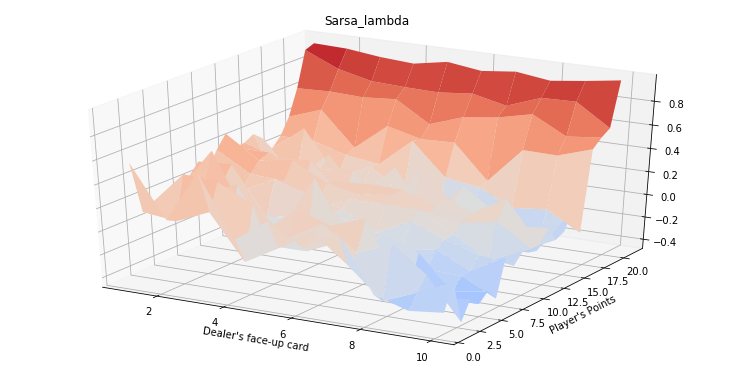

In [23]:
plot_Q_function(Q, "Sarsa_lambda")

In [71]:
# Q_learning Algorithm
from collections import defaultdict

def Q_Learning(MDP, episods, gamma = 1, alpha = 0.1, epsilon = 0.3):
    '''Q_Learning Algorithm for Off-policy Control
    
    Params:
        MDP: an instance of MDP
        episods: number of episod
        gamma: decay of reward
        alpha: parameter of TD-learning, learning rate
        epsilon: parameter of epsilon-greedy
        
    Return:
        Q, A defaultdict(np.ndarray)
        Q[state][value]: the estimate expect of state-action pair
    '''
    Q = defaultdict(lambda: np.zeros(MDP.action_space.n))
    policy = improve_greedy_policy(Q, epsilon, MDP.action_space.n)
    
    for i_episod in range(1, episods+1):
        if i_episod % 1000 == 0:
            print("\ri_episod:%d/%d"%(i_episod, episods), end="")
        
        s = MDP.reset()
        done = False
        
        while not done:
            prob = policy(s)
            a = np.random.choice(np.arange(len(prob)), p = prob)
            s_next, r, done, _ = MDP.step(a)
            if not done:
                Q[s][a] += alpha * (r + gamma * np.max(Q[s_next]) - Q[s][a])
                s = s_next
            else:
                Q[s][a] += alpha * (r + 0 - Q[s][a]) # Q(terminate-state,.) = 0
    return Q

In [29]:
env = Easy21()
Q = Q_Learning(env, 1000000, alpha = 0.05, epsilon = 0.15)

i_episod:1000000/1000000

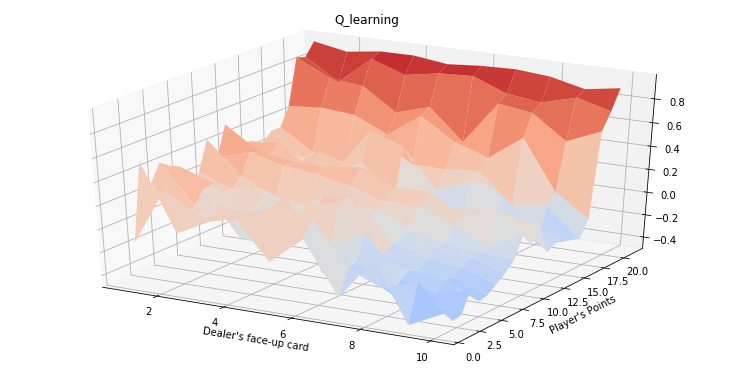

In [30]:
plot_Q_function(Q, "Q_learning")